In [6]:
import os
import pandas as pd
import numpy as np
# ! pip install supervenn
from supervenn import supervenn

import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_dropbox_dir
from standardize import fill_na_by_cohort, standardize_across_cohorts

## Load Important Stuff

In [ ]:
savefig_params = {'dpi': 300, 'bbox_inches': 'tight', 'pad_inches': 0.05}


### Directories

In [132]:
# %%
dropbox_dir = get_dropbox_dir()
base_dir = os.path.join(dropbox_dir, 'development_CohortCombination','alignment_RCC_2024_Feb_27')

ref_freq = 0.6
input_freq = 0.1
grid_id = 0
matt_ft_dir = os.path.join(base_dir, 'matt_top_fts')
data_dir = os.path.join(base_dir, 'alignment_id_31', f'merge_reference_freq_th_{ref_freq}_freq_th_{input_freq}')
# data_dir = os.path.join(base_dir, 'alignment_id_36', f'grid_search_index_{grid_id}')


cohort_ids_to_labels_file = os.path.join(base_dir, 'cohort_ids_to_labels.xlsx')
save_dir = os.path.join(data_dir,'plots')
os.makedirs(save_dir, exist_ok=True)
savefig_params = {'dpi': 300, 'bbox_inches': 'tight', 'pad_inches': 0.05}

## Key Peaks

### Matt's Features

In [133]:
# %%
matt_ft_files = os.listdir(matt_ft_dir)
matt_ft_files = [f for f in matt_ft_files if f.endswith('.txt')]

matt_ft_dict = {}
for f in matt_ft_files:
    ft_name = f.split('_feats')[0]
    # with open(os.path.join(matt_ft_dir, f), 'r') as file:
    #     ft = file.read().split(', ')
    # if len(ft) == 1:
    with open(os.path.join(matt_ft_dir, f), 'r') as file:
        ft = file.read().splitlines()
        # print(file.read()
    # remove all of the ', and commas from the strings in the list
    ft = [x.strip(',').strip(' ').strip('"').strip("'").strip('\n').strip('\t') for x in ft]
    matt_ft_dict[ft_name] = ft
    # break
    print(ft_name + ': ' + str(len(ft)))

top_10: 10
top_25: 25
168_os_pfs: 168
net_matched: 86


### RCC Target Metabolites

In [134]:
# %%
rcc_peak_info_file = os.path.join(base_dir, 'rcc_result', 'peak_info.csv')
rcc_peak_info_df = pd.read_csv(rcc_peak_info_file, index_col=0)

rcc_peak_info_df = rcc_peak_info_df[rcc_peak_info_df['freq'] >= ref_freq].copy()

print(f'Number of peaks in the reference cohort after {ref_freq} filter: ', rcc_peak_info_df.shape[0])

    
rcc_matched_targets_file = os.path.join(base_dir,'rcc_result', 'matched_targets HILIC POSITIVE ION MODE.csv')
rcc_matched_targets_df = pd.read_csv(rcc_matched_targets_file, index_col=0)
rcc_matched_targets_df.loc[rcc_peak_info_df.index]

potential_feats = rcc_matched_targets_df[rcc_matched_targets_df['potential_target']].index.to_list()
print('Number of features that potentially match to a target metabolite: ', len(potential_feats))

double_match_ids = rcc_matched_targets_df[rcc_matched_targets_df['potential_target_count'] > 1]
num_double_match = double_match_ids.shape[0]
print('Number of features that potentially match to more than one target metabolite: ', double_match_ids.shape[0])
print(rcc_matched_targets_df.loc[double_match_ids.index, 'potential_target_id'])

# here are the double matches in RCC, two are the same metabolite (but different adducts?)
# FT3202                           tryptophanTryptophan_μM
# FT3237                           kynurenineKynurenine_μM
# FT8451    C18:1 LPC plasmalogen_AC18:1 LPC plasmalogen_B


potential_feat_names = rcc_matched_targets_df.loc[potential_feats]['potential_target_id'].unique()
# print('Number of potential feature names: ', len(potential_feat_names))
print(potential_feat_names)

print('Number of target metabolite captured: ', len(potential_feat_names))

# for now don't remove the double counts, since they are NOT actually double counts
num_rcc_targets_found =  len(potential_feat_names)
rcc_target_feats = potential_feats

# add to the matt ft dictionary
matt_ft_dict['rcc_targets'] = rcc_target_feats


Number of peaks in the reference cohort after 0.6 filter:  4016
Number of features that potentially match to a target metabolite:  188
Number of features that potentially match to more than one target metabolite:  3
feats
FT3202                           tryptophanTryptophan_μM
FT3237                           kynurenineKynurenine_μM
FT8451    C18:1 LPC plasmalogen_AC18:1 LPC plasmalogen_B
Name: potential_target_id, dtype: object
['trimethylamine-N-oxide' 'alanine' 'GABA' 'serine' 'hypotaurine'
 'cytosine' 'creatinine' 'betaine' 'threonine' 'niacinamide' 'taurine'
 'ornithine' 'N-acetylalanine' 'N-carbamoyl-beta-alanine'
 'N-methylproline' 'leucine' 'hydroxyproline' 'N-acetylputrescine'
 '1-methylnicotinamide' 'trigonelline' 'anthranilic acid' 'urocanic acid'
 'imidazole propionate' 'ectoine' 'proline-betaine' 'glutamate'
 '4-acetamidobutanoate' 'butyrobetaine' 'glutamine' 'lysine' 'methionine'
 'N1-methyl-2-pyridone-5-carboxamide' '4-hydroxy-3-methylacetophenone'
 'guanine' 'allantoin

### Helper functions for dealing with the key features

In [135]:
# Helper functions to finding the number and percentage of captured features
def get_captured_fts(matt_ft_list, align_ft_list):
    captured_fts = [ft for ft in matt_ft_list if ft in align_ft_list]
    return captured_fts

def get_captured_perc(matt_ft_list, align_ft_list):
    captured_fts = get_captured_fts(matt_ft_list, align_ft_list)
    matt_capture_perc = len(captured_fts) / len(matt_ft_list)
    align_capture_perc = len(captured_fts) / len(align_ft_list)
    return matt_capture_perc, align_capture_perc


# check that the Matt feats are found in the RCC peaks
print('In the original RCC dataset at the {} frequency threshold:'.format(ref_freq))
for matt_ft_name, matt_ft_list in matt_ft_dict.items():
    captured_peaks = get_captured_fts(matt_ft_list, rcc_peak_info_df.index)
    print(f'Number of {matt_ft_name} captured: {len(captured_peaks)} out of {len(matt_ft_list)}')


In the original RCC dataset at the 0.6 frequency threshold:
Number of top_10 captured: 10 out of 10
Number of top_25 captured: 25 out of 25
Number of 168_os_pfs captured: 168 out of 168
Number of net_matched captured: 86 out of 86
Number of rcc_targets captured: 162 out of 188


## Prep Data and Metadata

In [136]:
# %%
cohort_id_file = os.path.join(data_dir, 'combined_study_cohort_ids.csv')
nan_mask_file = os.path.join(data_dir, 'combined_study_nan_mask.csv')
combined_study_file = os.path.join(data_dir, 'combined_study.csv')
align_score_file = os.path.join(data_dir, 'align_score_df.csv')
align_feats_file = os.path.join(data_dir, 'alignment_df.csv')


umap_file = os.path.join(data_dir, 'umap_df_zscore.csv')
pca_file = os.path.join(data_dir, 'pca_df_zscore.csv')

cohorts_to_rem = ['549']
print('removing cohorts: ', cohorts_to_rem)

removing cohorts:  ['549']


In [137]:
# %%
# Create the pretraining metadata
if '.csv' in cohort_ids_to_labels_file:
    cohort_ids_to_labels_df = pd.read_csv(cohort_ids_to_labels_file, index_col=0)
elif '.xlsx' in cohort_ids_to_labels_file:
    cohort_ids_to_labels_df = pd.read_excel(cohort_ids_to_labels_file, index_col=0)
else:
    raise ValueError('cohort_ids_to_labels_file must be a csv or xlsx file')

cohort_id_df = pd.read_csv(cohort_id_file, index_col=0)
cohort_id_df.set_index('file_name', inplace=True)
cohort_id_df.columns = ['cohort_id']
metadata_df = cohort_id_df.join(cohort_ids_to_labels_df, on='cohort_id')
# turn the cohort id into a string
metadata_df['cohort_id'] = metadata_df['cohort_id'].astype(str)


metadata_df = metadata_df[~metadata_df['cohort_id'].isin(cohorts_to_rem)]


study_id_to_label = metadata_df.groupby('Study ID')['Cohort Label'].first().to_dict()
cohort_id_to_label = metadata_df.groupby('cohort_id')['Cohort Label'].first().to_dict()
cohort_id_to_study_id = metadata_df.groupby('cohort_id')['Study ID'].first().to_dict()

# %%
# information about the reference cohort
ref_cohort_id = '541'
num_ref_cohort_peaks = rcc_peak_info_df.shape[0]
#TODO Save the number of peaks in the reference cohort used for alignment

# %%
# Get the alignment scores
align_scores = pd.read_csv(align_score_file, index_col=0)
align_scores.index = align_scores.index.astype(str)


cohort_id_to_align_score = align_scores.iloc[:,0].to_dict()
cohort_id_to_align_score[ref_cohort_id] = 1.0




In [138]:
# %%
# Create the unique color maps to consistent plotting across the different plots

# join the following colormaps Accent, Dark2, Set2, Pastel2
my_32_colors = plt.cm.Accent.colors + plt.cm.Dark2.colors + plt.cm.Set2.colors + plt.cm.Pastel2.colors
my_10_colors = plt.cm.tab10.colors
my_20_colors = plt.cm.tab20.colors 
my_42_colors = my_10_colors + my_32_colors
my_52_colors = my_20_colors + my_32_colors

def get_color_map(n):
    if n <= 10:
        return my_10_colors
    elif n <= 20:
        return my_20_colors
    elif n <= 32:
        return my_32_colors
    elif n <= 42:
        return my_42_colors
    elif n <= 52:
        return my_52_colors
    else:
        # create a colormap from turbo
        return plt.cm.turbo(np.linspace(0, 1, n))
    
def assign_color_map(unique_vals):
    my_colors = get_color_map(len(unique_vals))
    color_map = dict(zip(np.sort(unique_vals), my_colors))
    return color_map


In [139]:
# %%
# Create cohort ids for the RCC subsets
rcc1_files = [f for f in metadata_df.index if 'RCC_HP' in f]
print(len(rcc1_files))
rcc3_files = [f for f in metadata_df[metadata_df['cohort_id']==ref_cohort_id].index if 'RCC_HP' not in f]
print(len(rcc3_files))

metadata_df['Cohort ID Expanded'] = metadata_df['cohort_id']
metadata_df['Study ID Expanded'] = metadata_df['Study ID']
metadata_df.loc[rcc1_files, 'Cohort ID Expanded'] = 'RCC1'
metadata_df.loc[rcc3_files, 'Cohort ID Expanded'] = 'RCC3'
metadata_df.loc[rcc1_files, 'Study ID Expanded'] = 'ST001236'
metadata_df.loc[rcc3_files, 'Study ID Expanded'] = 'ST001237'


# %%
cohort_label_to_color = assign_color_map(metadata_df['Cohort Label'].unique())
study_id_to_color = {k:cohort_label_to_color[v] for k,v in study_id_to_label.items()}
cohort_id_to_color = {k:cohort_label_to_color[v] for k,v in cohort_id_to_label.items()}

study_id_to_uniq_color = assign_color_map(np.sort(metadata_df['Study ID'].unique()))
cohort_id_to_uniq_color = assign_color_map(np.sort(metadata_df['cohort_id'].unique()))

271
1379


In [140]:
metadata_df.to_csv(os.path.join(data_dir, 'metadata_df.csv'))

In [141]:
metadata_summary = pd.DataFrame()
metadata_summary['Cohort ID'] = metadata_df['cohort_id'].unique()
metadata_summary['Cohort ID'] = metadata_summary['Cohort ID'].astype(str)
metadata_summary['Cohort Label'] = metadata_summary['Cohort ID'].map(cohort_id_to_label)
metadata_summary['Study ID'] = metadata_summary['Cohort ID'].map(cohort_id_to_study_id)
metadata_summary['Number of Samples'] = metadata_summary['Cohort ID'].map(metadata_df['cohort_id'].value_counts())
metadata_summary['Alignment Score'] = metadata_summary['Cohort ID'].map(cohort_id_to_align_score)


In [142]:
metadata_summary

,Cohort ID,Cohort Label,Study ID,Number of Samples,Alignment Score
0,541,adult_cancer,RCC,1650,1.000000
1,502,adult_cancer,ST001422,2075,0.442145
2,503,pediatric_CMD,ST001428,1542,0.294514
3,504,adult_other,ST001849,691,0.240898
4,505,pediatric_other,ST001931,2046,0.263092
5,507,adult_other,ST002112,335,0.517706
6,509,pediatric_other,ST002331,1322,0.304738
7,522,adult_cancer,ST001408,349,0.543392
8,526,adult_cancer,ST001423,1197,0.439152
9,547,adult_other,ST000601,393,0.268847


## Compute Nan Mask Metrics

In [143]:
# Nan Mask turns into the "not nan" mask
nan_mask = pd.read_csv(nan_mask_file, index_col=0)
nan_mask.columns = nan_mask.columns.astype(str)
nan_mask = nan_mask[metadata_df.index]
nan_mask = ~nan_mask

In [144]:
# group_col = 'Study ID Expanded'
group_col = 'Study ID'
feat_ids = nan_mask.index

# group_samples = metadata_df[metadata_df[group_col] == 'ST001237'].index
group_samples = metadata_df[metadata_df[group_col] == 'RCC'].index

print('number of samples: ', len(group_samples))
group_feats = feat_ids[nan_mask[group_samples].any(axis=1)]
print('number of features: ', len(group_feats))

number of samples:  1650
number of features:  3895


In [196]:
def compute_alignment_metrics(not_nan_mask, key_feat_dict, sample_ids=None, feat_ids=None):


    # columns are the samples, rows are the features
    # not_nan_mask is the inverse of the nan_mask, True values indicate the feature has a value that is NOT NaN

    if sample_ids is None:
        sample_ids = not_nan_mask.columns
    if feat_ids is None:
        feat_ids = not_nan_mask.index

    feat_df = pd.DataFrame(index=feat_ids)
    sample_df = pd.DataFrame(index=sample_ids)


    metrics_dct = {}
    metrics_dct['num input samples'] = len(sample_ids)
    metrics_dct['num input feats'] = len(feat_ids)

    # group features are the number of features found in at least one sample in the group
    group_feats = feat_ids[not_nan_mask.loc[feat_ids,sample_ids].any(axis=1)]
    feat_df['found'] = False
    feat_df.loc[group_feats, 'found'] = True
    metrics_dct['num found feats'] = len(group_feats)

    # sample_group_freq is the number of samples in the group that have a value for the feature
    sample_group_freq = not_nan_mask.loc[group_feats,sample_ids].sum(axis=1) / len(sample_ids)
    feat_df['freq'] = np.nan
    feat_df.loc[group_feats,'freq'] = sample_group_freq
    metrics_dct['average feat freq'] = sample_group_freq.mean()

    # feat_group_freq is the number of group-features in the group that have a value for the sample
    feat_group_freq = not_nan_mask.loc[group_feats,sample_ids].sum(axis=0) / len(group_feats)
    sample_df['freq'] = feat_group_freq
    sample_df['overall freq'] = not_nan_mask.loc[feat_ids,sample_ids].sum(axis=0) / len(feat_ids)
    metrics_dct['average sample freq'] = feat_group_freq.mean()
    metrics_dct['average overall sample freq'] = sample_df['overall freq'].mean()


    metrics_dct['value fraction'] = not_nan_mask.loc[group_feats,sample_ids].sum().sum()/ (len(group_feats) * len(sample_ids))
    metrics_dct['value frac ALL FEATs'] = not_nan_mask.loc[feat_ids,sample_ids].sum().sum() / (len(feat_ids) * len(sample_ids))

    for key_name, key_feats in key_feat_dict.items():

        # print(key_name)
        captured_feats = [ft for ft in key_feats if ft in feat_ids]
        key_sample_group_freq = not_nan_mask.loc[captured_feats,sample_ids].sum(axis=1) / len(sample_ids)
        feat_df[key_name] = np.nan
        feat_df.loc[captured_feats, key_name] = key_sample_group_freq

        key_feat_group_freq = not_nan_mask.loc[captured_feats,sample_ids].sum(axis=0) / len(key_feats)
        sample_df[key_name] = key_feat_group_freq

        specific_captured_peaks = get_captured_fts(key_feats, group_feats)
        metrics_dct[key_name + ' captured frac'] = len(specific_captured_peaks) / len(key_feats)

    metrics_dct['num samples below group 10%'] = (sample_df['freq'].fillna(0) < 0.1).sum()
    metrics_dct['num samples below overall 10%'] = (sample_df['overall freq'].fillna(0) < 0.1).sum()

    return metrics_dct, feat_df, sample_df
    # return metrics_dct


In [146]:
group_col = 'Study ID Expanded'
unique_group_cols = metadata_df[group_col].unique()

all_metrics = []

for group_id in unique_group_cols:
    group_samples = metadata_df[metadata_df[group_col] == group_id].index

    metrics_dct, feat_df, sample_df = compute_alignment_metrics(nan_mask, matt_ft_dict, group_samples.to_list())
    metrics_dct['study_id'] = group_id
    all_metrics.append(metrics_dct)

all_metrics_df = pd.DataFrame(all_metrics)
all_metrics_df.to_csv(os.path.join(data_dir, 'alignment_result_metrics.csv'))

In [147]:
# group_col = 'Study ID Expanded'
# group_id = 'ST000422'
# group_samples = metadata_df[metadata_df[group_col] == group_id].index
# metrics_dct, feat_df, sample_df = compute_alignment_metrics(nan_mask, matt_ft_dict, group_samples.to_list())
# print(metrics_dct)

In [148]:
# sample_df['freq'].hist()

In [24]:
# feat_df.hist(column='freq', bins=50)

## Analysis of Choosing different thresholds for Frequency and min number of files

In [25]:
group_col = 'Study ID Expanded'

group_freq = []
overall_freq = []
group_feats_dict = {}
group_samples_dict = {}
feat_ids = nan_mask.index


for sample_id in metadata_df.index:
    group_id = metadata_df.loc[sample_id, group_col]
    if group_id not in group_feats_dict.keys():
        print(group_id)
        # group_feats[group_id] = feat_ids[nan_mask[metadata_df[metadata_df[group_col] == group_id].index].any(axis=0)]
        group_samples = metadata_df[metadata_df[group_col] == group_id].index
        print('number of samples: ', len(group_samples))
        group_feats = feat_ids[nan_mask[group_samples].any(axis=1)]
        print('number of aligned features: ', len(group_feats))
        group_feats_dict[group_id] = group_feats


    group_freq.append(nan_mask.loc[group_feats_dict[group_id], sample_id].mean())

    overall_freq.append(nan_mask.loc[:, sample_id].mean())


metadata_df['group_freq'] = group_freq
metadata_df['overall_freq'] = overall_freq

ST001237
number of samples:  1379
number of aligned features:  3897
ST001236
number of samples:  271
number of aligned features:  3512


ST001931
number of samples:  2046
number of aligned features:  1028
ST002331
number of samples:  1322
number of aligned features:  1234
ST002251
number of samples:  253
number of aligned features:  1081
ST001428
number of samples:  1542
number of aligned features:  1245
ST000909
number of samples:  744
number of aligned features:  1365
ST001932
number of samples:  4488
number of aligned features:  1886
ST001849
number of samples:  691
number of aligned features:  895
ST002112
number of samples:  335
number of aligned features:  2037
ST000601
number of samples:  393
number of aligned features:  708
ST001099
number of samples:  102
number of aligned features:  834
ST002244
number of samples:  122
number of aligned features:  1576
ST002027
number of samples:  356
number of aligned features:  1065
ST001918
number of samples:  271
number of aligned features:  1291
ST001519
number of samples:  166
number of aligned features:  2308
ST001422
number of samples:  2075
number of aligned features:

In [149]:
# How many features are found in each group?
print('Number of features found in each group:')
for group_id, group_feats in group_feats_dict.items():
    print(group_id, ':', len(group_feats))

Number of features found in each group:
ST001237 : 3897
ST001236 : 3512
ST001931 : 1028
ST002331 : 1234
ST002251 : 1081
ST001428 : 1245
ST000909 : 1365
ST001932 : 1886
ST001849 : 895
ST002112 : 2037
ST000601 : 708
ST001099 : 834
ST002244 : 1576
ST002027 : 1065
ST001918 : 1291
ST001519 : 2308
ST001422 : 1744
ST001408 : 2130
ST001423 : 1751
ST000422 : 741
ST000388 : 2186


In [150]:
sns.displot(metadata_df, x='group_freq', hue=group_col, kind='kde')

ValueError: Could not interpret value `group_freq` for `x`. An entry with this name does not appear in `data`.

In [ ]:
# Frequency of each peak within each group
print('group col:', group_col)

feat_group_freq_info = pd.DataFrame()
feat_group_freq_info.index = nan_mask.index

for group_id, group_feats in group_feats_dict.items():
    group_samples = metadata_df[metadata_df[group_col] == group_id].index
    feat_group_freq_info[group_id] = nan_mask.loc[group_feats,group_samples].mean(axis=1)


num_samples_per_group = metadata_df.groupby(group_col).size()   


feat_group_num_samples = feat_group_freq_info * num_samples_per_group

group col: Study ID Expanded


In [ ]:
feat_fewest_samples = feat_group_num_samples.min(axis=1)
feat_smallest_freq = feat_group_freq_info.min(axis=1)

In [ ]:
# Try different thresholds and see how that changes the number of features
min_num_samples = 10
min_freq = 0.1
feat_ids = feat_group_freq_info.index
print('number of features before frequency filtering: ', len(feat_ids))

new_feats = feat_ids[(feat_fewest_samples > min_num_samples) & (feat_smallest_freq > min_freq)]
print('number of features after frequency filtering: ', len(new_feats))

# check overlap with Matt features
for matt_ft_name, matt_ft_list in matt_ft_dict.items():
    captured_peaks = get_captured_fts(matt_ft_list, new_feats)
    print(f'Number of {matt_ft_name} captured: {len(captured_peaks)} out of {len(matt_ft_list)}')

number of features before frequency filtering:  3898
number of features after frequency filtering:  3643
Number of top_10 captured: 10 out of 10
Number of top_25 captured: 25 out of 25
Number of 168_os_pfs captured: 160 out of 168
Number of net_matched captured: 84 out of 86
Number of rcc_targets captured: 157 out of 188


In [ ]:
print('group col:', group_col)

out_dct_list = []
for min_num_samples in range(0,40):
    for min_freq in [0.1,0.15,0.2,0.25,0.30,0.35]:
        new_feats = feat_ids[(feat_fewest_samples > min_num_samples) & (feat_smallest_freq > min_freq)]
        
        out_dict = {'min_num_samples': min_num_samples, 'min_freq': min_freq, 'num_feats': len(new_feats)}

        for matt_ft_name, matt_ft_list in matt_ft_dict.items():
            captured_peaks = get_captured_fts(matt_ft_list, new_feats)
            out_dict[f'num_{matt_ft_name}'] = len(captured_peaks)
            out_dict[f'frac_{matt_ft_name}'] = len(captured_peaks)/ len(matt_ft_list)
        out_dct_list.append(out_dict)

out_df = pd.DataFrame(out_dct_list)

group col: Study ID Expanded


Text(0, 0.5, 'Fraction of features captured')

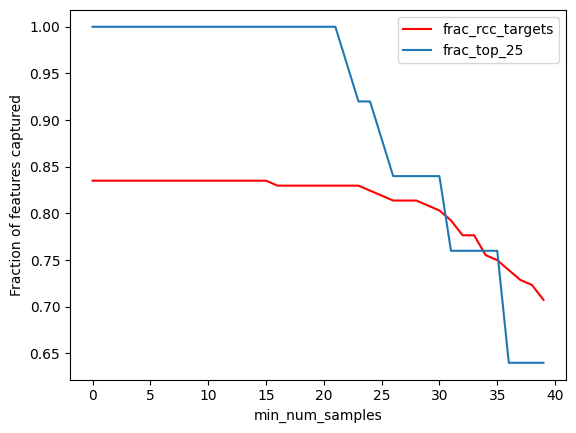

In [ ]:
# out_df.plot(x='min_num_samples', y='num_feats', label='num_feats')
ax, fig = plt.subplots()
out_df[out_df['min_freq']==0.1].plot(x='min_num_samples', y='frac_rcc_targets', label='frac_rcc_targets', kind='line', ax=fig, color='r')
out_df[out_df['min_freq']==0.1].plot(x='min_num_samples', y='frac_top_25', label='frac_top_25', kind='line', ax=fig)
plt.ylabel('Fraction of features captured')
plt.savefig(os.path.join(save_dir, 'feature_capture_vs_sample_num_thresh.png'), **savefig_params)
# plt.close()

Text(0, 0.5, 'Fraction of features captured')

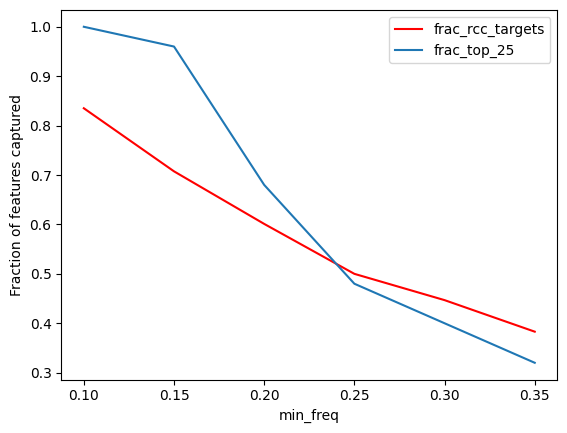

In [ ]:
# out_df.plot(x='min_num_samples', y='num_feats', label='num_feats')
ax, fig = plt.subplots()
out_df[out_df['min_num_samples']==10].plot(x='min_freq', y='frac_rcc_targets', label='frac_rcc_targets', kind='line', ax=fig, color='r')
out_df[out_df['min_num_samples']==10].plot(x='min_freq', y='frac_top_25', label='frac_top_25', kind='line', ax=fig)
plt.ylabel('Fraction of features captured')
plt.savefig(os.path.join(save_dir, 'feature_capture_vs_min_freq.png'), **savefig_params)
# plt.close()


In [151]:
print('group col:', group_col)
group_freq_dct = {}
group_sz_dct = {}
for group_id in metadata_df[group_col].unique():
    group_samples = metadata_df[metadata_df[group_col]==group_id].index
    val = nan_mask[group_samples].mean(axis=1)
    group_freq_dct[group_id] = val
    group_sz_dct[group_id] = len(group_samples)

group_freq_df = pd.DataFrame(group_freq_dct)
group_sz_df = pd.DataFrame(group_sz_dct, index=['Number of Samples']).T

group col: Study ID Expanded


In [152]:
group_freq_df

,ST001237,ST001236,ST001422,ST001428,ST001849,ST001931,ST002112,ST002331,ST001408,ST001423,...,ST000422,ST001099,ST002251,ST000909,ST002244,ST002027,ST001918,ST001932,ST000388,ST001519
FT10031,0.548223,0.948339,0.000000,0.920233,0.000000,0.269795,0.000000,0.000000,0.126074,0.000000,...,0.766667,0.303922,0.0,0.000000,0.000000,0.000000,0.000000,0.391934,0.736842,0.000000
FT10035,0.986947,0.000000,0.000000,0.810636,0.000000,0.000000,0.000000,0.000000,0.197708,0.000000,...,0.133333,0.294118,0.0,0.000000,0.000000,0.000000,0.571956,0.355615,0.978947,0.000000
FT10037,0.551849,0.944649,0.301205,0.396239,0.000000,0.751222,0.000000,0.000000,0.656160,0.000000,...,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.656863,1.000000,0.000000
FT10039,0.987672,0.000000,0.124337,0.710117,0.000000,0.000000,0.000000,0.000000,0.664756,0.000000,...,0.783333,0.294118,0.0,0.000000,0.000000,0.353933,0.000000,0.585116,0.000000,0.000000
FT10040,0.997099,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.715789,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FT9988,0.873096,0.848708,0.000000,0.000000,0.843705,0.000000,0.298507,0.489410,0.882521,0.000000,...,0.000000,0.539216,0.0,0.857527,0.696721,0.000000,0.000000,0.000000,0.000000,0.993976
FT9989,0.985497,0.000000,0.000000,0.293774,0.000000,0.000000,0.000000,0.700454,0.421203,0.852130,...,0.833333,0.284314,0.0,0.634409,0.000000,0.000000,0.000000,0.485963,0.884211,0.000000
FT9995,0.986947,0.000000,0.000000,0.698444,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.294118,0.0,0.000000,0.000000,0.000000,0.000000,0.384358,0.000000,0.000000
FT9997,0.957941,0.000000,0.000000,0.661479,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.294118,0.0,0.000000,0.000000,0.000000,0.000000,0.518271,0.978947,0.000000


## Bar Plots by the Cohort and Study Ids

In [153]:
print('total number of samples', metadata_summary['Number of Samples'].sum())


total number of samples 18257


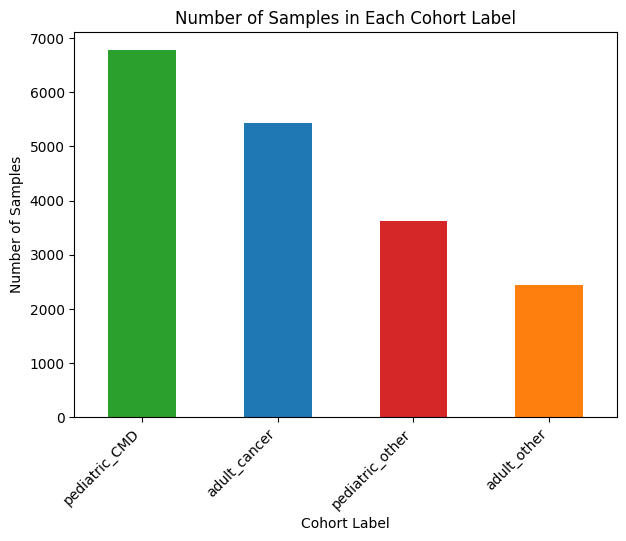

In [154]:
fig, ax = plt.subplots(figsize=(7,5))
temp = metadata_summary.groupby('Cohort Label')['Number of Samples'].sum().sort_values(ascending=False)
temp.plot(kind='bar', ax=ax, color=[cohort_label_to_color[label] for label in temp.index])
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples in Each Cohort Label')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.savefig(os.path.join(save_dir, 'num_samples_per_cohort_label.png'), **savefig_params)
# plt.close()

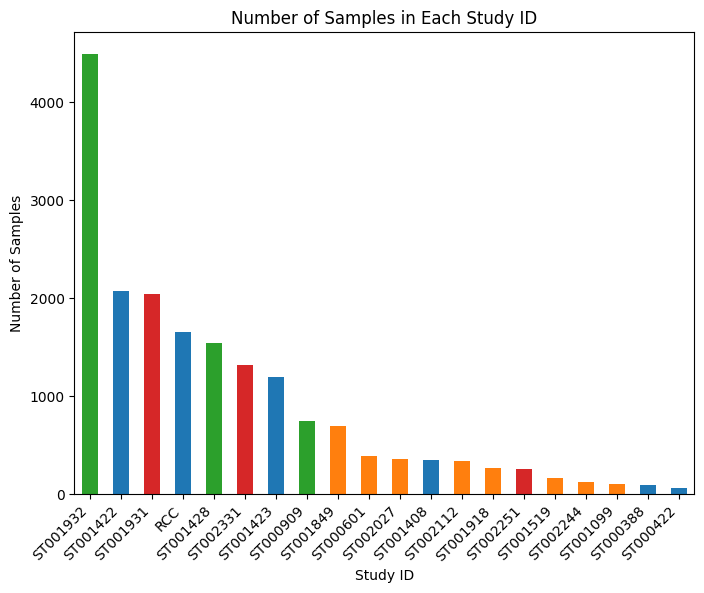

In [155]:
fig, ax = plt.subplots(figsize=(8,6))
temp = metadata_summary.groupby('Study ID')['Number of Samples'].sum().sort_values(ascending=False)
temp.plot(kind='bar', ax=ax, color=[study_id_to_color[label] for label in temp.index])
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples in Each Study ID')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.savefig(os.path.join(save_dir, 'num_samples_per_study_id.png'), **savefig_params)
# plt.close()

[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[WARNING] /var/folders/zk/pr84pr3n16z3yzz_rrstxmmc0000gn/T/ipykernel_93480/4182109543.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')



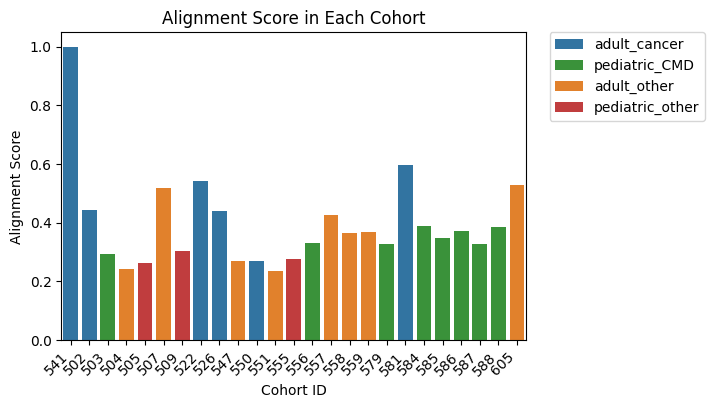

In [156]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=metadata_summary, x='Cohort ID', y='Alignment Score', palette=cohort_label_to_color, hue='Cohort Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('Alignment Score')
ax.set_title('Alignment Score in Each Cohort')
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(save_dir, 'alignment_score_per_cohort.png'), **savefig_params)
# plt.close()

## Peak Robustness Analysis

In [157]:
def compute_peak_robustness(alignment_df, nan_mask, metadata_summary,metadata_df,
                            ref_id=ref_cohort_id,group_col='Study ID Expanded'):

    # num_samples = metadata_df[group_col].value_counts()

    num_samples = metadata_summary[['Cohort ID','Number of Samples']].copy()
    num_samples.set_index('Cohort ID', inplace=True)
    total_num_samples = num_samples['Number of Samples'].sum()
    align_summary =  alignment_df.copy()
    align_summary.index = align_summary[ref_id]
    # align_summary.set_index(ref_id, inplace=True)

    nan_locs = align_summary.isna()
    ref_fts = align_summary.index

    for col in align_summary.columns:
        align_summary[col] = ref_fts

    align_summary[nan_locs] = None
    align_summary = align_summary.astype(bool).astype(int).T
    align_summary.index.name = 'Cohort ID'

    align_summary_cohortsize_weighted = align_summary.mul(num_samples['Number of Samples'], axis=0)

    # weight is by the size of the cohort
    peak_robustness_1 = align_summary_cohortsize_weighted.sum(axis=0)/total_num_samples

    # each cohort is weighted equally
    peak_robustness_2 = align_summary.sum(axis=0)/align_summary.shape[0]

    # each weight is by the log(size) of the cohort
    align_summary_logcohortsize_weighted = np.log(1 + align_summary_cohortsize_weighted)
    log_tot_num_samples = np.sum(1+ np.log(num_samples['Number of Samples']))
    peak_robustness_3 = align_summary_logcohortsize_weighted.sum(axis=0)/log_tot_num_samples


    # the peak frequency across the cohorts
    # cohort_peak_frequency = nan_mask.sum(axis=1)

    group_freq_dct = {}
    group_sz_dct = {}
    for group_id in metadata_df[group_col].unique():
        cohort_samples = metadata_df[metadata_df[group_col]==group_id].index
        # val = 1 - nan_mask[cohort_samples].mean(axis=1) #if nan mask is actually locations of nans
        val = nan_mask[cohort_samples].mean(axis=1) #if nan mask is actually locations of the not nans
        group_freq_dct[group_id] = val
        group_sz_dct[group_id] = len(cohort_samples)

    group_freq_df = pd.DataFrame(group_freq_dct)
    group_sz_df = pd.DataFrame(group_sz_dct, index=['Number of Samples']).T

    # the peak frequency across the group, each group weighted by size
    peak_robustness_4 = group_freq_df.mul(group_sz_df['Number of Samples'], axis=1).sum(axis=1)/group_sz_df['Number of Samples'].sum()
    

    # the peak frequency across the group, each group weighted by log(size)
    group_log_sz_df = np.log(1 + group_sz_df)
    log_group_sz_df = group_freq_df.mul(group_log_sz_df['Number of Samples'], axis=1).sum(axis=1)/group_log_sz_df['Number of Samples'].sum()
    peak_robustness_5 = log_group_sz_df


    peak_robustness_dct = {
        'Found, Cohort Equal Weighted': peak_robustness_2,
        'Found, Cohort Size Weighted': peak_robustness_1,
        'Found, Cohort Log Size Weighted': peak_robustness_3,
        'Freq, Cohort Size Weighted': peak_robustness_4,
        'Freq, Cohort Log Size Weighted': peak_robustness_5
    }

    return peak_robustness_dct

In [158]:
# Load the original alignment summary
alignment_df = pd.read_csv(align_feats_file)
alignment_df.columns = alignment_df.columns.astype(str)
alignment_df.dropna(axis=0, how='all', inplace=True)
alignment_df = alignment_df[metadata_summary['Cohort ID'].unique()]

# %% Compute different peak robustness scores

# %%
peak_robustness_dct = compute_peak_robustness(alignment_df, nan_mask, metadata_summary, metadata_df)


In [159]:
robustness_df = pd.DataFrame(peak_robustness_dct)
robustness_df.to_csv(os.path.join(data_dir, 'peak_robustness.csv'))

## Create the H-clustering Plots

In [160]:
peak_robust_name =  'Found, Cohort Size Weighted'
# peak_robust_name  = 'Freq, Cohort Log Size Weighted'
peak_robust_th = 0.2

In [161]:
feat_info = pd.DataFrame(index=alignment_df[ref_cohort_id])
feat_info.index.name = 'Aligned Features'
for k,v in matt_ft_dict.items():
    feat_info[k] = False
    overlap = [x for x in v if x in feat_info.index]
    print(f'From {k} there are {len(overlap)} aligned out of {len(v)} features.')
    feat_info.loc[overlap, k] = True

From top_10 there are 10 aligned out of 10 features.
From top_25 there are 25 aligned out of 25 features.
From 168_os_pfs there are 165 aligned out of 168 features.
From net_matched there are 86 aligned out of 86 features.
From rcc_targets there are 162 aligned out of 188 features.


In [162]:
group_col = 'cohort_id'    
group_freq_dct = {}
group_sz_dct = {}
for group_id in metadata_df[group_col].unique():
    cohort_samples = metadata_df[metadata_df[group_col]==group_id].index
    val = nan_mask[cohort_samples].mean(axis=1)
    group_freq_dct[group_id] = val
    group_sz_dct[group_id] = len(cohort_samples)

group_freq_df = pd.DataFrame(group_freq_dct)
group_sz_df = pd.DataFrame(group_sz_dct, index=['Number of Samples']).T

feat_info = feat_info.join(group_freq_df)

In [163]:
group_freq_df

,541,502,503,504,505,507,509,522,526,547,...,558,559,579,581,584,585,586,587,588,605
FT10031,0.613939,0.000000,0.920233,0.000000,0.269795,0.000000,0.000000,0.126074,0.000000,0.0,...,0.000000,0.000000,0.489960,0.736842,0.190921,0.483957,0.350267,0.429144,0.407754,0.000000
FT10035,0.824848,0.000000,0.810636,0.000000,0.000000,0.000000,0.000000,0.197708,0.000000,0.0,...,0.000000,0.571956,0.423025,0.978947,0.299065,0.191176,0.375668,0.442513,0.402406,0.000000
FT10037,0.616364,0.301205,0.396239,0.000000,0.751222,0.000000,0.000000,0.656160,0.000000,0.0,...,0.000000,0.000000,0.702811,1.000000,0.667557,0.633690,0.645722,0.672460,0.618984,0.000000
FT10039,0.825455,0.124337,0.710117,0.000000,0.000000,0.000000,0.000000,0.664756,0.000000,0.0,...,0.353933,0.000000,0.576975,0.000000,0.491322,0.584225,0.581551,0.613636,0.663102,0.000000
FT10040,0.997576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.715789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FT9988,0.869091,0.000000,0.000000,0.843705,0.000000,0.298507,0.489410,0.882521,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.993976
FT9989,0.823636,0.000000,0.293774,0.000000,0.000000,0.000000,0.700454,0.421203,0.852130,0.0,...,0.000000,0.000000,0.491299,0.884211,0.388518,0.568182,0.233957,0.644385,0.589572,0.000000
FT9995,0.824848,0.000000,0.698444,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.000000,0.000000,0.519411,0.000000,0.391188,0.348930,0.560160,0.000000,0.486631,0.000000
FT9997,0.800606,0.000000,0.661479,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.000000,0.000000,0.463186,0.978947,0.528705,0.435829,0.508021,0.645722,0.528075,0.000000


In [73]:
group_sz_df

,Number of Samples
541,1650
505,2046
509,1322
555,253
503,1542
556,744
579,747
584,749
585,748
586,748


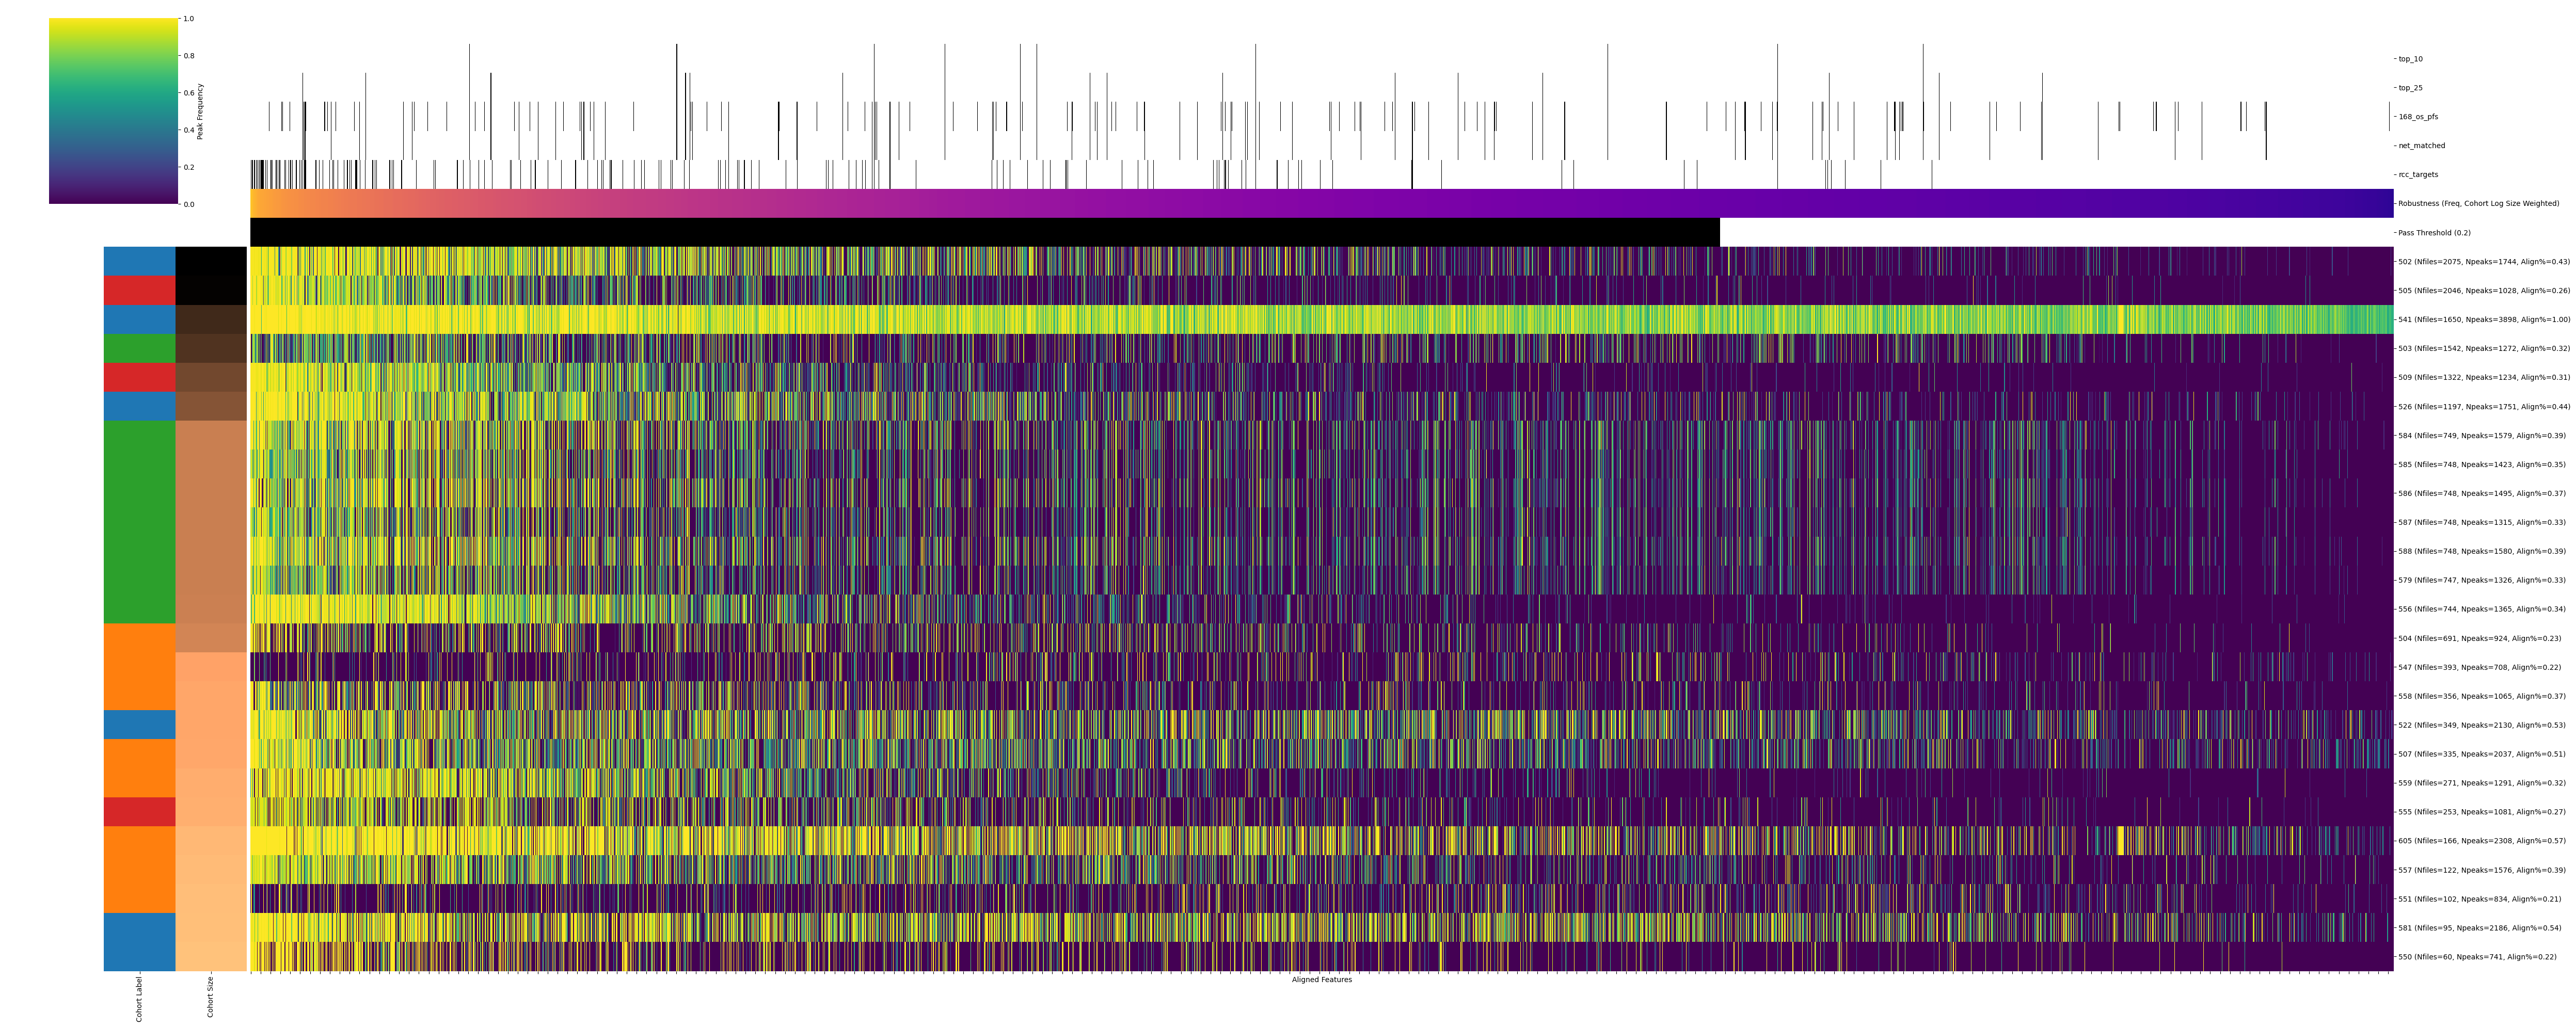

In [74]:
col_cluster = False
row_cluster = False

cohort_ids = metadata_df['cohort_id'].unique()
plot_df = feat_info[cohort_ids].T

col_colors = pd.DataFrame(index=plot_df.columns)
for col in feat_info.columns:
    if col in cohort_ids:
        continue
    col_colors[col] = feat_info[col].map({True: 'black', False: 'white'})

col_colors[f'Robustness ({peak_robust_name})'] = peak_robustness_dct[peak_robust_name].map(lambda x: plt.cm.plasma(x))
col_colors[f'Pass Threshold ({peak_robust_th})'] = (peak_robustness_dct[peak_robust_name] > peak_robust_th).map({True: 'black', False: 'white'})

####
# Change the names of the rows
cohort_id_to_sample_num = metadata_summary[['Cohort ID','Number of Samples']].copy()
cohort_id_to_sample_num.set_index('Cohort ID', inplace=True)
align_summary_bool = ~alignment_df.isna()
align_counts = align_summary_bool.sum(axis=0)

if col_cluster==False:
    col_val_order = peak_robustness_dct[peak_robust_name]
    col_val_order.sort_values(ascending=False, inplace=True)
    plot_df = plot_df[col_val_order.index]

if row_cluster==False:
    row_val_order = group_sz_df['Number of Samples'].copy()
    row_val_order.sort_values(ascending=False, inplace=True)
    plot_df = plot_df.loc[row_val_order.index]


row_colors = pd.DataFrame(index=plot_df.index)
row_colors['Cohort Label'] = [cohort_id_to_color[c] for c in plot_df.index]
row_colors['Cohort Size'] = [group_sz_df.loc[c, 'Number of Samples'] for c in plot_df.index]
row_colors['Cohort Size'] = row_colors['Cohort Size']/row_colors['Cohort Size'].max()
row_colors['Cohort Size'] = row_colors['Cohort Size'].map(lambda x: plt.cm.copper_r(x))




new_row_names = [f'{c} (Nfiles={cohort_id_to_sample_num.loc[c].values[0]}, Npeaks={align_counts[c]:.0f}, Align%={cohort_id_to_align_score[c]:.2f})' 
        for c in plot_df.index]





plot_df.index =  new_row_names
row_colors.index = new_row_names

g = sns.clustermap(plot_df, cmap='viridis', figsize=(50,20), 
            row_colors=row_colors, col_colors=col_colors, 
            col_cluster=col_cluster, row_cluster=row_cluster,
            dendrogram_ratio=0.04)

plt.setp(g.ax_heatmap.get_xticklabels(), visible=False)
# add a label to the colorbar 
g.cax.set_ylabel('Peak Frequency')



plt.savefig(os.path.join(save_dir, 'supervenn_clustermap.png'), **savefig_params)
# plt.close()

Text(178.85866013071896, 0.5, 'Peak Frequency')

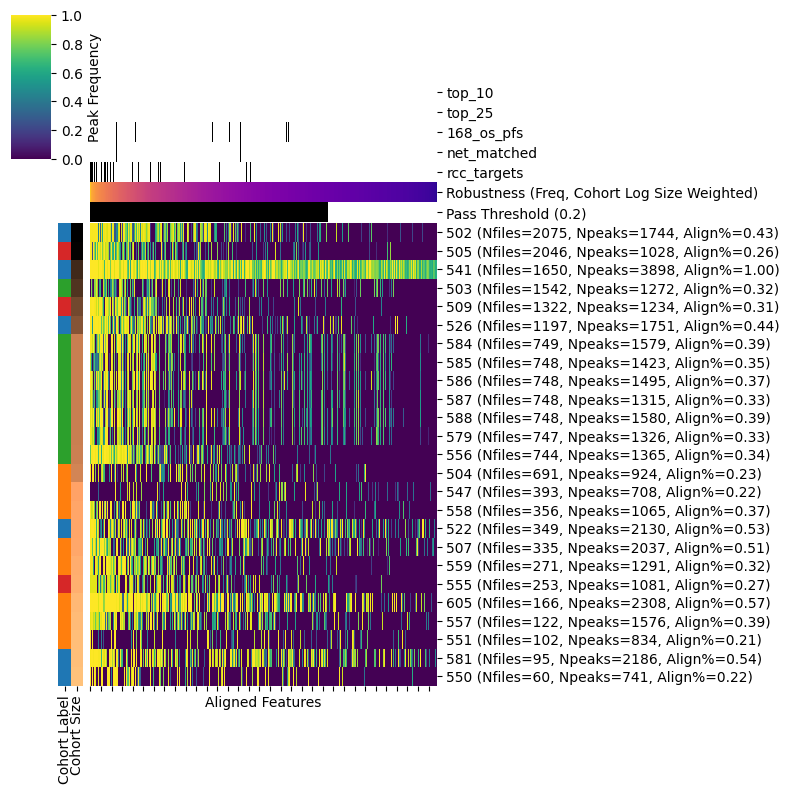

In [75]:
col_cluster = False
row_cluster = False

cohort_ids = metadata_df['cohort_id'].unique()
plot_df = feat_info[cohort_ids].T

col_colors = pd.DataFrame(index=plot_df.columns)
for col in feat_info.columns:
    if col in cohort_ids:
        continue
    col_colors[col] = feat_info[col].map({True: 'black', False: 'white'})

col_colors[f'Robustness ({peak_robust_name})'] = peak_robustness_dct[peak_robust_name].map(lambda x: plt.cm.plasma(x))
col_colors[f'Pass Threshold ({peak_robust_th})'] = (peak_robustness_dct[peak_robust_name] > peak_robust_th).map({True: 'black', False: 'white'})

####
# Change the names of the rows
cohort_id_to_sample_num = metadata_summary[['Cohort ID','Number of Samples']].copy()
cohort_id_to_sample_num.set_index('Cohort ID', inplace=True)
# align_summary_bool = alignment_df.astype(bool)
align_summary_bool = ~alignment_df.isna()
align_counts = align_summary_bool.sum(axis=0)

if col_cluster==False:
    col_val_order = peak_robustness_dct[peak_robust_name]
    col_val_order.sort_values(ascending=False, inplace=True)
    plot_df = plot_df[col_val_order.index]

if row_cluster==False:
    row_val_order = group_sz_df['Number of Samples'].copy()
    row_val_order.sort_values(ascending=False, inplace=True)
    plot_df = plot_df.loc[row_val_order.index]


row_colors = pd.DataFrame(index=plot_df.index)
row_colors['Cohort Label'] = [cohort_id_to_color[c] for c in plot_df.index]
row_colors['Cohort Size'] = [group_sz_df.loc[c, 'Number of Samples'] for c in plot_df.index]
row_colors['Cohort Size'] = row_colors['Cohort Size']/row_colors['Cohort Size'].max()
row_colors['Cohort Size'] = row_colors['Cohort Size'].map(lambda x: plt.cm.copper_r(x))




new_row_names = [f'{c} (Nfiles={cohort_id_to_sample_num.loc[c].values[0]}, Npeaks={align_counts[c]:.0f}, Align%={cohort_id_to_align_score[c]:.2f})' 
        for c in plot_df.index]





plot_df.index =  new_row_names
row_colors.index = new_row_names

g = sns.clustermap(plot_df, cmap='viridis', figsize=(8,8), 
            row_colors=row_colors, col_colors=col_colors, 
            col_cluster=col_cluster, row_cluster=row_cluster,
            dendrogram_ratio=0.1)

plt.setp(g.ax_heatmap.get_xticklabels(), visible=False)
# add a label to the colorbar 
g.cax.set_ylabel('Peak Frequency')

plt.savefig(os.path.join(save_dir, 'supervenn_clustermap_small.png'), **savefig_params)
# plt.close()


In [48]:
savefig_params

{'dpi': 300, 'bbox_inches': 'tight', 'pad_inches': 0.05}

In [164]:
# feat_info_2 = feat_info.copy()
# feat_info_2['label'] = 'others'
# feat_info_2.loc[feat_info_2['168_os_pfs'], 'label'] = '168_os_pfs'
# feat_info_2.loc[feat_info_2['net_matched'], 'label'] = 'net_matched'
# feat_info_2.loc[feat_info_2['top_25'], 'label'] = 'top_25'

# for k,v in peak_robustness_dct.items():
#     feat_info_2[k] = v




feat_info_2 = feat_info.copy()
feat_info_2['label'] = 'others'
feat_info_2.loc[feat_info_2['rcc_targets'], 'label'] = 'rcc_targets'
feat_info_2.loc[feat_info_2['net_matched'], 'label'] = 'net_matched'
feat_info_2.loc[feat_info_2['top_25'], 'label'] = 'top_25'

for k,v in peak_robustness_dct.items():
    feat_info_2[k] = v    

In [165]:
for k in peak_robustness_dct.keys():

    # fig, ax = plt.subplots(figsize=(8,6))
    sns.displot(data=feat_info_2, x=k, hue='label', fill=True, multiple='stack')
    ax.set_title(k)
    plt.savefig(os.path.join(save_dir, f'x_{k}_hist.png'), **savefig_params)
    plt.close()

    # fig, ax = plt.subplots(figsize=(8,6))
    sns.displot(data=feat_info_2, x=k, hue='label', fill=True, kind='kde', common_norm=False, bw_adjust=0.5)
    ax.set_title(k)
    plt.savefig(os.path.join(save_dir, f'x_{k}_kde.png'), **savefig_params)
    plt.close()


In [166]:
# sns.displot(data=feat_info_2, x='Found, Cohort Size Weighted', hue='label', fill=True, multiple='stack')

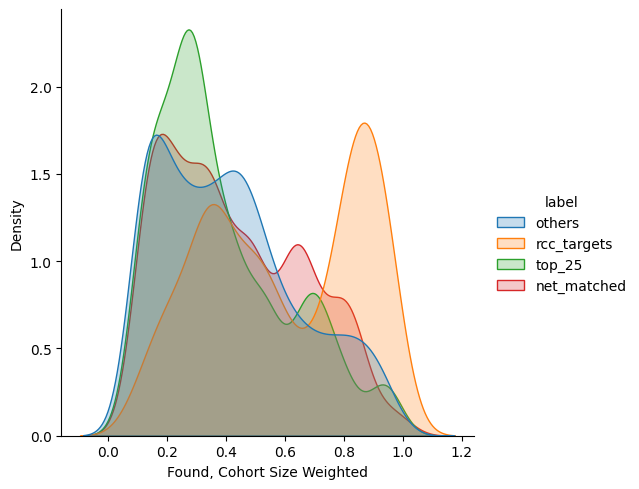

In [167]:
sns.displot(data=feat_info_2, x='Found, Cohort Size Weighted', hue='label', fill=True, kind='kde', common_norm=False, bw_method=0.25)

In [53]:
matt_ft_dict.keys()

dict_keys(['top_10', 'top_25', '168_os_pfs', 'net_matched', 'rcc_targets'])

In [168]:
chosen_robustness_metric_list= peak_robustness_dct.keys()

for chosen_robustness_metric in chosen_robustness_metric_list:
    robustnesss_thresholds = [0,0.05,0.1,0.15,0.2,0.25,0.3, 0.33, 0.35, 0.4, 0.45, 0.5]
    captured_info_list = []
    for threshold in robustnesss_thresholds:

        captured_peaks = feat_info_2[feat_info_2[chosen_robustness_metric] > threshold].index

        # sparsity_val = 1 - nan_mask.loc[captured_peaks].mean().mean()
        overall_freq = nan_mask.loc[captured_peaks].mean().mean()

        num_samples_below_10 = (nan_mask.loc[captured_peaks].mean(axis=1) < 0.1).sum()

        captured_info = {
            'robustness threshold': threshold,
            'number of peaks': len(captured_peaks),
            'overall freq': overall_freq,
            # '% of RCC peaks': get_captured_perc(rcc_peak_info_df.index, captured_peaks)[0],
            '% of RCC peaks': len(captured_peaks)/num_ref_cohort_peaks,
            '% of Matt top 25': get_captured_perc(matt_ft_dict['top_25'], captured_peaks)[0],
            '% of network peaks': get_captured_perc(matt_ft_dict['net_matched'], captured_peaks)[0],
            '% of RCC targets': get_captured_perc(matt_ft_dict['rcc_targets'], captured_peaks)[0],
            'num samples below 10% freq': num_samples_below_10
        }

        captured_info_list.append(captured_info)
        print(f'Number of peaks with robustness greater than {threshold}: ', (feat_info_2[chosen_robustness_metric] > threshold).sum())


    captured_df = pd.DataFrame(captured_info_list)

    captured_df.to_csv(os.path.join(save_dir, f'captured_info_{chosen_robustness_metric}.csv'))

Number of peaks with robustness greater than 0:  3895
Number of peaks with robustness greater than 0.05:  3892
Number of peaks with robustness greater than 0.1:  3724
Number of peaks with robustness greater than 0.15:  3492
Number of peaks with robustness greater than 0.2:  2957
Number of peaks with robustness greater than 0.25:  2712
Number of peaks with robustness greater than 0.3:  2451
Number of peaks with robustness greater than 0.33:  2153
Number of peaks with robustness greater than 0.35:  2153
Number of peaks with robustness greater than 0.4:  1622
Number of peaks with robustness greater than 0.45:  1363
Number of peaks with robustness greater than 0.5:  1140
Number of peaks with robustness greater than 0:  3895
Number of peaks with robustness greater than 0.05:  3895
Number of peaks with robustness greater than 0.1:  3824
Number of peaks with robustness greater than 0.15:  3284
Number of peaks with robustness greater than 0.2:  2996
Number of peaks with robustness greater than

## Get a subset of the data using the robustness metrics

In [169]:
# peak_robust_name =  'Found, Cohort Size Weighted'
# peak_robust_th = 0.25


subset_id = f'robust_{peak_robust_name}_{peak_robust_th}'
subset_dir = os.path.join(data_dir, 'subset_'+subset_id)
os.makedirs(subset_dir, exist_ok=True)

In [170]:
rcc_metadata_file = os.path.join(dropbox_dir, 'development_CohortCombination','clean_rcc_metadata.csv')

desc_str = subset_id
rcc_metadata = pd.read_csv(rcc_metadata_file, index_col=0)
metadata = pd.read_csv(os.path.join(data_dir, 'metadata_df.csv'), index_col=0)
peak_robustness = pd.read_csv(os.path.join(data_dir, 'peak_robustness.csv'), index_col=0)
# Join the two metadata together
metadata = metadata.join(rcc_metadata, how='outer')
metadata.to_csv(os.path.join(data_dir, 'subset_metadata_with_rcc.csv'))
robust_score = peak_robustness[peak_robust_name]
keep_peaks = peak_robustness[robust_score >=peak_robust_th].index
keep_samples = metadata.index

print(f'Keeping {len(keep_peaks)} peaks and {len(keep_samples)} samples')

Keeping 2996 peaks and 18257 samples


In [124]:
# group_id = 'ST001237'
# group_samples = metadata_df[metadata_df[group_col] == group_id].index

# metrics_dct, feat_df, sample_df = compute_alignment_metrics(nan_mask, matt_ft_dict, group_samples.to_list(), keep_peaks)

In [197]:
group_col = 'Study ID Expanded'
unique_group_cols = metadata_df[group_col].unique()

all_metrics = []



for group_id in unique_group_cols:
    group_samples = metadata_df[metadata_df[group_col] == group_id].index

    metrics_dct, feat_df, sample_df = compute_alignment_metrics(nan_mask, matt_ft_dict, group_samples.to_list(), keep_peaks)
    metrics_dct['study_id'] = group_id
    all_metrics.append(metrics_dct)

all_metrics_df = pd.DataFrame(all_metrics)
all_metrics_df.to_csv(os.path.join(subset_dir, 'alignment_result_metrics.csv'))

In [190]:
feat_df

,found,freq,top_10,top_25,168_os_pfs,net_matched,rcc_targets
FT10031,False,NaN,NaN,NaN,NaN,NaN,NaN
FT10035,False,NaN,NaN,NaN,NaN,NaN,NaN
FT10037,False,NaN,NaN,NaN,NaN,NaN,NaN
FT10039,False,NaN,NaN,NaN,NaN,NaN,NaN
FT10041,True,0.746988,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
FT9984,True,0.969880,NaN,NaN,NaN,NaN,NaN
FT9988,True,0.993976,NaN,NaN,NaN,NaN,NaN
FT9989,False,NaN,NaN,NaN,NaN,NaN,NaN
FT9995,False,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
all_metrics_df #['num samples below overall 10%'].sum()

,num input samples,num input feats,num found feats,average feat freq,average sample freq,average overall sample freq,value fraction,value frac ALL FEATs,top_10 captured frac,top_25 captured frac,168_os_pfs captured frac,net_matched captured frac,rcc_targets captured frac,num samples below 10%,num samples below overall 10%,study_id
0,1379,2996,2996,0.881703,0.881703,0.881703,0.881703,0.881703,0.8,0.76,0.761905,0.790698,0.808511,0,0,ST001237
1,271,2996,2729,0.868289,0.868289,0.790908,0.868289,0.790908,0.8,0.76,0.726190,0.790698,0.808511,0,0,ST001236
2,2075,2996,1772,0.715004,0.715004,0.422893,0.715004,0.422893,0.6,0.56,0.541667,0.569767,0.696809,22,24,ST001422
3,1542,2996,1174,0.631394,0.631394,0.247415,0.631394,0.247415,0.1,0.20,0.238095,0.197674,0.250000,5,20,ST001428
4,691,2996,880,0.731392,0.731392,0.214828,0.731392,0.214828,0.2,0.28,0.232143,0.186047,0.292553,0,0,ST001849
5,2046,2996,1054,0.647896,0.647896,0.227931,0.647896,0.227931,0.1,0.24,0.297619,0.232558,0.473404,0,2,ST001931
6,335,2996,1693,0.643847,0.643847,0.363829,0.643847,0.363829,0.6,0.52,0.488095,0.534884,0.643617,0,0,ST002112
7,1322,2996,1208,0.660644,0.660644,0.266375,0.660644,0.266375,0.2,0.24,0.357143,0.337209,0.500000,1,9,ST002331
8,349,2996,1799,0.709162,0.709162,0.425829,0.709162,0.425829,0.3,0.28,0.398810,0.348837,0.484043,0,0,ST001408
9,1197,2996,1690,0.660815,0.660815,0.372756,0.660815,0.372756,0.4,0.36,0.482143,0.476744,0.638298,5,5,ST001423


In [194]:
metrics_dct, feat_df, sample_df = compute_alignment_metrics(nan_mask, matt_ft_dict, nan_mask.columns.to_list(), keep_peaks)

In [187]:
len(nan_mask.columns.to_list())

18257

In [195]:
metrics_dct

{'num input samples': 18257,
 'num input feats': 2996,
 'num found feats': 2996,
 'average feat freq': 0.35543120318976357,
 'average sample freq': 0.3554312031897636,
 'average overall sample freq': 0.3554312031897636,
 'value fraction': 0.3554312031897636,
 'value frac ALL FEATs': 0.3554312031897636,
 'top_10 captured frac': 0.8,
 'top_25 captured frac': 0.76,
 '168_os_pfs captured frac': 0.7619047619047619,
 'net_matched captured frac': 0.7906976744186046,
 'rcc_targets captured frac': 0.8085106382978723,
 'num samples below 10%': 81}

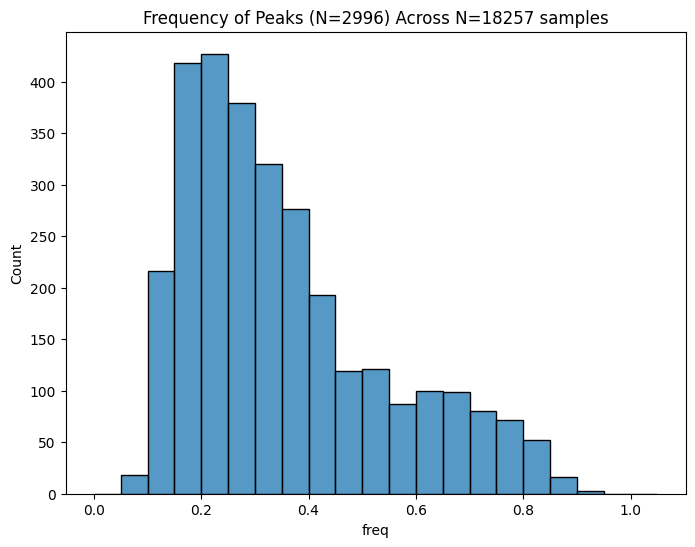

In [185]:
# histogram of the frequency of the peaks

fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=feat_df, x='freq', bins=np.arange(0,1.1,0.05))
ax.set_title('Frequency of Peaks (N={}) Across N={} samples'.format(len(feat_df), len(sample_df)))
plt.savefig(os.path.join(subset_dir, 'peak_freq_hist.png'), **savefig_params)
# plt.close()

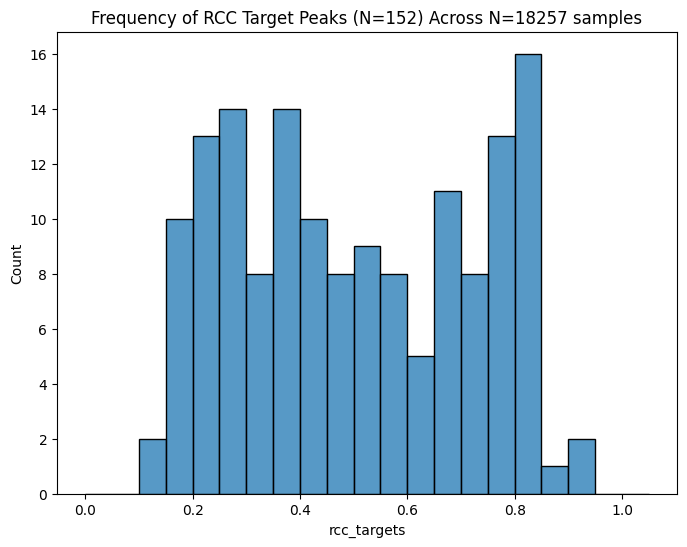

In [184]:
# histogram of frequency of the RCC target peaks
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=feat_df, x='rcc_targets', bins=np.arange(0,1.1,0.05))
ax.set_title('Frequency of RCC Target Peaks (N={}) Across N={} samples'.format(feat_df['rcc_targets'].notna().sum(), len(sample_df)))
plt.savefig(os.path.join(subset_dir, 'rcc_target_freq_hist.png'), **savefig_params)
# plt.close()

In [182]:
temp

FT10314    0.256888
FT10583    0.681547
FT10812    0.349510
FT10815    0.233061
FT10826    0.747385
             ...   
FT9543     0.387413
FT9605     0.282357
FT9606     0.471874
FT9928     0.288163
FT9975     0.505724
Name: rcc_targets, Length: 152, dtype: float64

In [ ]:
# group_samples = metadata_df[metadata_df[group_col] == group_id].index
# metrics_dct, feat_df, sample_df = compute_alignment_metrics(nan_mask, matt_ft_dict, nan_mask.columns.to_list(), keep_peaks)

In [174]:
metrics_dct

{'num input samples': 18257,
 'num input feats': 2996,
 'num found feats': 2996,
 'average feat freq': 0.35543120318976357,
 'average sample freq': 0.3554312031897636,
 'value fraction': 0.3554312031897636,
 'value frac ALL FEATs': 0.3554312031897636,
 'top_10 captured frac': 0.8,
 'top_25 captured frac': 0.76,
 '168_os_pfs captured frac': 0.7619047619047619,
 'net_matched captured frac': 0.7906976744186046,
 'rcc_targets captured frac': 0.8085106382978723,
 'num samples below 10%': 18}

In [ ]:

# data_corrected = pd.read_csv(os.path.join(data_dir, 'subset_data_corrected.csv'), index_col=0)
# nan_mask = pd.read_csv(os.path.join(data_dir, 'subset_nan_mask.csv'), index_col=0)

combined_study = pd.read_csv(os.path.join(data_dir, 'combined_study.csv'), index_col=0)
nan_mask = pd.read_csv(os.path.join(data_dir, 'combined_study_nan_mask.csv'), index_col=0)
combined_study.columns = combined_study.columns.astype(str)
nan_mask.columns = nan_mask.columns.astype(str)
combined_study = combined_study.loc[keep_peaks, keep_samples].copy()
nan_mask = nan_mask.loc[keep_peaks, keep_samples].copy()



metadata['MV'] = 100*nan_mask.sum(axis=0)/nan_mask.shape[0]



        # %%
num_missing_vals = nan_mask.sum(axis=0).sort_values(ascending=False)
num_missing_frac = num_missing_vals/combined_study.shape[0]

# fig, ax = plt.subplots(figsize=(6,4))
# sns.histplot(num_missing_frac, bins=np.linspace(0,1,21), ax=ax)
# plt.xlabel('Missing Value Fraction')
# plt.ylabel('Number of Samples')
# plt.title('Histogram of Missing Value Fraction')
# plt.savefig(os.path.join(save_dir, f'missing_value_fraction_hist_subset_{min_num_cohort_ids}.png'), **savefig_params)
# plt.close()

# %%
# Remove samples with more than 95% missing values
mis_val_frac_th = 0.95
print(f'number of samples with more than {100*mis_val_frac_th:.0f}% missing values: ', (num_missing_frac > mis_val_frac_th).sum())
kept_samples = num_missing_frac[num_missing_frac < mis_val_frac_th].index
nan_mask = nan_mask.loc[:,kept_samples]
combined_study = combined_study.loc[:,kept_samples]
subset_metadata = metadata.loc[kept_samples]
cohort_id_list = subset_metadata['Cohort ID Expanded'].tolist()

print('combined_study shape after removing samples with more than 95% missing values: ', combined_study.shape)

# %%
# If we want to fill the NA values with something else
combined_study[nan_mask] = np.nan
# we want to split up the RCC cohorts into its subsets
combined_study = fill_na_by_cohort(combined_study, cohort_id_list, method= 'mean_1th')

# %%
data_corrected = standardize_across_cohorts(combined_study, cohort_id_list, method='zscore')
print('data_corrected shape: ', data_corrected.shape)
# which columns have been removed?
rem_cols = data_corrected.isna().sum() > 0
rem_cols = rem_cols[rem_cols].index
print('Number of columns removed: ', rem_cols.shape[0])
print('Columns removed: ', rem_cols)
data_corrected.dropna(axis=1, inplace=True)
print('data_corrected shape after dropping NA columns: ', data_corrected.shape)
subset_metadata = subset_metadata.loc[data_corrected.columns]
# Choose to look at only a subset of the data

# subset_metadata = metadata[metadata['Cohort Label'].isin(['adult_cancer','adult_other'])].copy()
subset_nan_mask = nan_mask[subset_metadata.index]

# successively remove the worst samples and features based on the nan_mask
# for thresh in [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]:
for thresh in [0.95, 0.9]:
    subset_nan_mask = subset_nan_mask[subset_metadata.index]
    good_samples = subset_nan_mask.sum(axis=0) < subset_nan_mask.shape[0]*thresh
    subset_nan_mask = subset_nan_mask[good_samples[good_samples].index]
    good_features = subset_nan_mask.sum(axis=1) < subset_nan_mask.shape[1]*thresh
    subset_nan_mask = subset_nan_mask.loc[good_features[good_features].index]
    subset_metadata = subset_metadata.loc[subset_nan_mask.columns]
    print(subset_nan_mask.shape)

# Assign the new subsets to overwrite the original data
if True:

    data_corrected = data_corrected.loc[subset_nan_mask.index, subset_nan_mask.columns]
    nan_mask = nan_mask.loc[subset_nan_mask.index, subset_nan_mask.columns]
    metadata = metadata.loc[subset_nan_mask.columns]
    print(metadata.shape, data_corrected.shape, nan_mask.shape)


    # remove the features with zero variance
    # good_features2 = data_corrected.var(axis=1) > 0
    # good_features2= good_features2[good_features2].index
    # data_corrected = data_corrected.loc[good_features2]
    # nan_mask = nan_mask.loc[good_features2]
    # print(metadata.shape, data_corrected.shape, nan_mask.shape)

    (data_corrected.T).to_csv(os.path.join(subset_dir, 'X.csv'))
    metadata.to_csv(os.path.join(subset_dir, 'y.csv'))
    (nan_mask.T).to_csv(os.path.join(subset_dir, 'nans.csv'))

## Create UMAP and PCA Plots

In [ ]:
def create_plot(plot_df, hue_col, palette_dict,include_MV=True,sz=None):
    if 'UMAP1' in plot_df.columns:
        x_col = 'UMAP1'
        y_col = 'UMAP2'
    else:
        x_col = 'PC1'
        y_col = 'PC2'

    if sz is None:
        sz = 10/np.log2(plot_df.shape[0])
        print('marker size: ', sz)

    fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(data=plot_df, x=x_col, y=y_col, hue=hue_col, palette=palette_dict, ax=ax, s=sz)
    
        # place the legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # edit the legend to include the number of samples in each cohort
    handles, labels = ax.get_legend_handles_labels()
    if include_MV:
        labels = [f'{label} (N={plot_df[plot_df[hue_col]==label].shape[0]}, MV%={plot_df[plot_df[hue_col]==label]["MV"].mean():.0f})' for label in labels]
    else:
        labels = [f'{label} (N={plot_df[plot_df[hue_col]==label].shape[0]})' for label in labels]

    # make the size of the markers in the handles larger
    for handle in handles:
        # print(dir(handle))
        handle.set_markersize(10)
        # handle._sizes = [100]
    
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return fig, ax

In [ ]:
import umap
from sklearn.decomposition import PCA

In [ ]:
pca_file_subset = os.path.join(data_dir, f'pca_df_zscore_subset_{subset_id}.csv')

pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_corrected.T)
pca_df = pd.DataFrame(pca_result, index=data_corrected.columns, columns=['PC1', 'PC2'])
pca_df['MV'] = subset_metadata['MV']
pca_df['Cohort Label'] = subset_metadata['Cohort Label']
pca_df['Study ID'] = subset_metadata['Study ID']
pca_df['Cohort ID'] = subset_metadata['cohort_id']

# save the pca_df
pca_df.to_csv(pca_file_subset)

In [ ]:
# create_plot(pca_df, 'Cohort Label', cohort_label_to_color)
# plt.xlim([-100,100])
# plt.ylim([-50,50])

In [ ]:
# create_plot(pca_df, 'Study ID', study_id_to_uniq_color)
# plt.xlim([-100,100])
# plt.ylim([-50,50])

In [ ]:

# %%
create_plot(pca_df, 'Cohort Label', cohort_label_to_color)
plt.savefig(os.path.join(save_dir, f'pca_cohort_label_subset_{subset_id}.png'), **savefig_params)
plt.close()

# error occurs here?
create_plot(pca_df, 'Study ID', study_id_to_uniq_color)
plt.savefig(os.path.join(save_dir, f'pca_study_id_uniq_color_subset_{subset_id}.png'), **savefig_params)
plt.close()

# %% [markdown]

In [ ]:
# ### UMAP Plot
umap_file_subset = os.path.join(data_dir, f'umap_df_zscore_subset_{subset_id}.csv')


# %%
umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(data_corrected.T)

In [ ]:
umap_df = pd.DataFrame(umap_result, index=data_corrected.columns, columns=['UMAP1', 'UMAP2'])
umap_df['MV'] = subset_metadata['MV']
umap_df['Cohort Label'] = subset_metadata['Cohort Label']
umap_df['Study ID'] = subset_metadata['Study ID']
umap_df['Cohort ID'] = subset_metadata['cohort_id']

# save the umap_df
umap_df.to_csv(umap_file_subset)

In [ ]:
create_plot(umap_df, 'Cohort Label', cohort_label_to_color)
plt.savefig(os.path.join(save_dir, f'umap_cohort_label_subset_{subset_id}.png'), **savefig_params)
# plt.close()

In [ ]:
create_plot(umap_df, 'Study ID', study_id_to_uniq_color)
plt.savefig(os.path.join(save_dir, f'umap_study_id_uniq_color_subset_{subset_id}.png'), **savefig_params)
# plt.close()

In [ ]:
# create_plot(umap_df, 'Study ID', study_id_to_uniq_color)
# plt.xlim([2.5,15])
# plt.ylim([5,10])